In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 6.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=21cb60ac7cfdbc26c84a159f307d778a1389537b2b81957f9f790b982eede235
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, Xception, VGG16,InceptionV3,EfficientNetB1
from keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

In [3]:
from google.colab import files
data_to_load = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.74G/5.76G [01:45<00:00, 49.0MB/s]
100% 5.76G/5.76G [01:45<00:00, 58.8MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('cassava-leaf-disease-classification.zip', 'r')
zip_ref.extractall('cassava-leaf-disease-classification')
zip_ref.close()

In [7]:
WORK_DIR = os.getcwd()+'/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['test_tfrecords',
 'label_num_to_disease_map.json',
 'test_images',
 'train_tfrecords',
 'train.csv',
 'sample_submission.csv',
 'train_images']

In [8]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [9]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [10]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


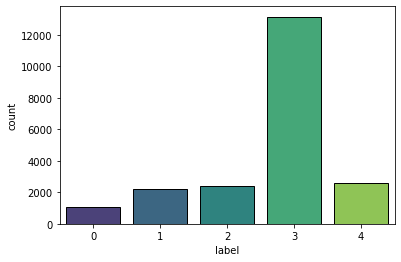

In [11]:
sns.countplot(train_labels.label, edgecolor = 'black',
              palette = sns.color_palette("viridis", 5))
plt.show()

We have imbalanced data with domination of third class: "Cassava Mosaic Disease (CMD)". Let's see how our model performs with this imbalanced dataset. It might not have an effect so we'll keep it in the training dataset for now.

### Some photos of dominant class (with CMD)

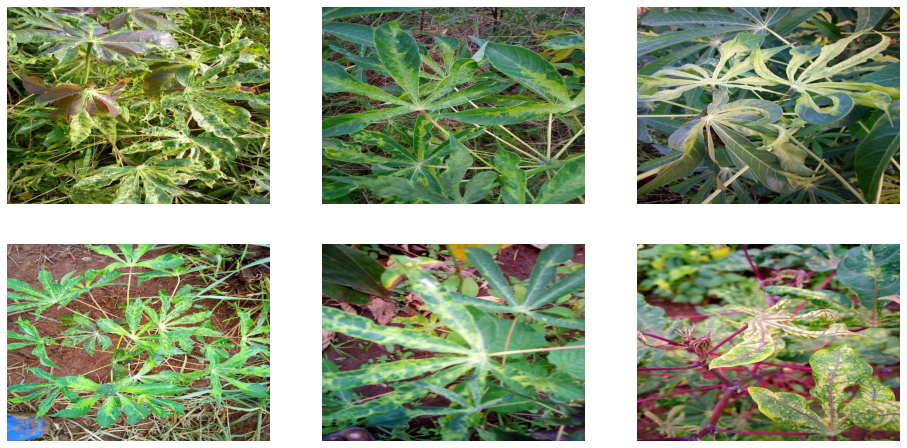

In [12]:
sample = train_labels[train_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

### Some photos of healthy plants

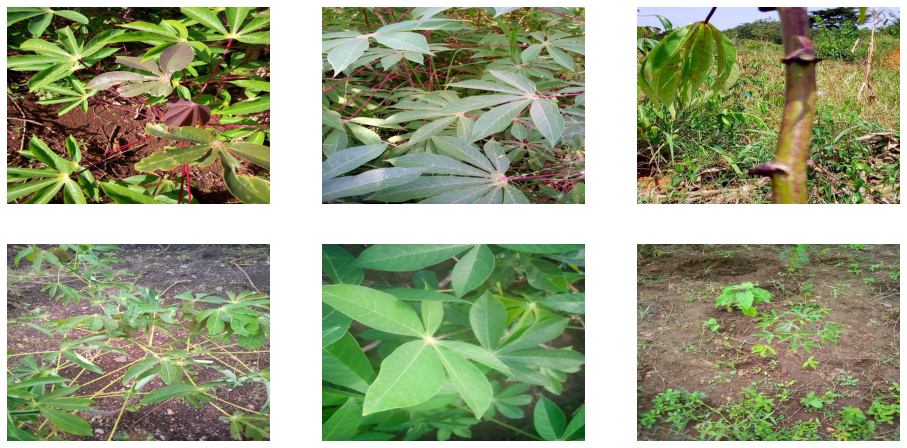

In [13]:
sample = train_labels[train_labels.label == 4].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

## The baseline level of accuracy

In [14]:
y_pred = [3] * len(train_labels.label)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, train_labels.label,normalize=True))

The baseline accuracy: 0.615


Our future model must have accuracy better than 0.615.

## Modeling

In [15]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 299

In [16]:
train_labels.label = train_labels.label.astype('str')
#validation_split parameter allows for us to split 20% of the data into the validation set automatically without train test split
#Then you can allow .flow_from_dataframe to breakout the train versus validation in the data
train_generator = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     rotation_range = 5,
                                     fill_mode = 'constant',
                                     shear_range = 0.2,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


I will try EfficientNetB1. It will be my baseline NN for future improvements.

In [22]:
def create_model():
  base_model = keras.applications.EfficientNetB1(
                        weights='imagenet',
                        include_top=True,
                        pooling=None,
                        classes = 1000)
  for layer in base_model.layers[:len(base_model.layers)-80]:
        layer.trainable = False
  base_model._layers.pop()
  base_model2 = Model(base_model.input, base_model.layers[-1].output)
  x=keras.layers.Dense(5, activation='softmax')(base_model2.output)
  model=Model(base_model2.input,x)
  model.compile(optimizer = Adam(lr = 0.001),
                loss = "sparse_categorical_crossentropy",
                metrics = ["acc"])
  return model

In [23]:
model = create_model()

In [24]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 240, 240, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 240, 240, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 241, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [25]:
model_save = ModelCheckpoint('./best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
    )

Epoch 1/20
268/267 [==============================] - ETA: 0s - loss: 0.6466 - acc: 0.7674
Epoch 00001: val_loss improved from inf to 0.57645, saving model to ./best_baseline_model.h5
268/267 [==============================] - 434s 2s/step - loss: 0.6466 - acc: 0.7674 - val_loss: 0.5765 - val_acc: 0.8011
Epoch 2/20
268/267 [==============================] - ETA: 0s - loss: 0.5175 - acc: 0.8169
Epoch 00002: val_loss improved from 0.57645 to 0.55571, saving model to ./best_baseline_model.h5
268/267 [==============================] - 430s 2s/step - loss: 0.5175 - acc: 0.8169 - val_loss: 0.5557 - val_acc: 0.8179
Epoch 3/20
268/267 [==============================] - ETA: 0s - loss: 0.4761 - acc: 0.8329
Epoch 00003: val_loss did not improve from 0.55571
268/267 [==============================] - 434s 2s/step - loss: 0.4761 - acc: 0.8329 - val_loss: 0.6435 - val_acc: 0.7717
Epoch 4/20
268/267 [==============================] - ETA: 0s - loss: 0.4431 - acc: 0.8406
Epoch 00004: val_loss improve

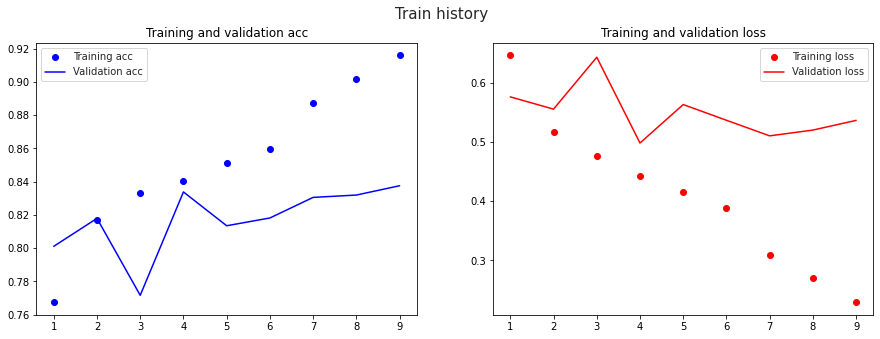

In [27]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [28]:

model.save('./baseline_model.h5')

In [29]:

ss = pd.read_csv(os.path.join(WORK_DIR, "sample_submission.csv"))
ss

,image_id,label
0,2216849948.jpg,4


In [30]:

preds = []

for image_id in ss.image_id:
    image = Image.open(os.path.join(WORK_DIR,  "test_images", image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

ss['label'] = preds
ss

,image_id,label
0,2216849948.jpg,4


In [31]:

ss.to_csv('submission.csv', index = False)

In [32]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

os.chdir(os.getcwd()+'/drive/MyDrive/Cassava-Leaf-Disease-Classification')
print('The Current Working Directory is: ',os.getcwd())

In [34]:

model.save('./baseline_model.h5')